In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
# from sklearn.preprocessing import label_binarize
# from sklearn import preprocessing
# from sklearn import tree 

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as scio
# import hiddenlayer as h
from visdom import Visdom
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torchviz import make_dot

import datetime
import os 

import sys
sys.path.append("..")
from utils.reuse import *
from utils.networks import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# 以下是检查点路径
# 请在当前环境下 CMD 输入python -m visdom.server 或 visdom 启动监视器
# 数据处理现在已移至 emgDataprocess.ipynb
model_Dir = './/model//emgmk_cnn_0323_nl//'
if not os.path.exists(model_Dir):
    os.makedirs(model_Dir)

ckpDir = model_Dir+'ckp//'
if not os.path.exists(ckpDir):
    os.makedirs(ckpDir)

ckpDir_auc = './/ckp//emgmk_cnn_0323_nl//auc//'
if not os.path.exists(ckpDir_auc):
    os.makedirs(ckpDir_auc)

def get_current_time():
    return datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
print(get_current_time())

timeForSave = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

2022_05_01_19_31_14


In [4]:
# 以下是 visdom 监视窗口初始化，实现每次启用时重新加载，这里只写了 NameError 以防其他错误不能被发现
class visdom_account:
    def __init__(self):    
        self.port = 8097
        self.server = "http://localhost"
        self.base_url = "/"
        self.username = "admin"
        self.passward = "1234"
        self.evns = "train42"
viz_acnt = visdom_account()
vislogDir = model_Dir+'vislog//'
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
def viz_init():
    try:
        viz
    except NameError:
        viz = Visdom(env=viz_acnt.evns,log_to_filename=vislogDir+'vislog_'+timeForSave)
        print('visdom has started')
    else:
        viz.close()
        del viz
        print('last visdom session closed')
        viz = Visdom(env=viz_acnt.evns,log_to_filename=vislogDir+'vislog_'+timeForSave)
        print('visdom has restarted')
    return viz
viz = viz_init()

Setting up a new session...


visdom has started


In [5]:
# 自定义神经网络,CNN
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# hdreshape = 32*1*3
hdreshape = 2
hdlayer_1 = 16
hdlayer_2 = 16
hdlayer_3 = 256
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128,\
             kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,\
             kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, \
            kernel_size=3, padding=0)

        self.fc1 = nn.Linear(in_features=128*1*3, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        # self.fc3 = nn.Linear(in_features=hdlayer_2, out_features=hdlayer_3)
        self.out = nn.Linear(in_features=128, out_features=3)
        self.dr1 = nn.Dropout2d(0.2)

    def forward(self, t):
        # (1) input layer
        t = t
        # t = t.reshape(1,1,3)
        # t = t.unsqueeze(0)

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (3) hidden conv layer
        # t = self.conv2(t)
        # t = F.relu(t)
        # t = self.dr1(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (4) hidden linear layer
        t = t.reshape(-1, 128*1*3)
        # t = t.flatten(start_dim=0)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        # t = self.fc3(t)
        # t = F.relu(t)
        # t = self.dr1(t)

        # (5) output layer
        t = self.out(t)

        return t

net = Network()
# 打印网络，检查输入输出 shape是否正确
# print(net)
samplebatchsize = 1
summary(net,(1,1,3),batch_size = samplebatchsize,device = "cpu")
sampleInput = torch.randn(samplebatchsize,1,1,3).requires_grad_(True)
sampleOutput = net(sampleInput)
print('Outputshape:',sampleOutput.shape)
# framevision = make_dot(sampleOutput, params=dict(list(net.named_parameters()) + [('x',sampleInput)]))
# framevision.format = "png"
# framevision.direcory = "./"
# framevision.view()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 128, 1, 3]           1,280
            Linear-2                   [1, 128]          49,280
            Linear-3                   [1, 128]          16,512
            Linear-4                     [1, 3]             387
Total params: 67,459
Trainable params: 67,459
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.26
Estimated Total Size (MB): 0.26
----------------------------------------------------------------
Outputshape: torch.Size([1, 3])


In [6]:

dataarray = np.load('../data/220319emgsk/withTrueTime/EMGSKdata-220323.npy',allow_pickle=True)
CNNdataset = dataarray.item()
print(type(CNNdataset))
# 加载自变量：
data_cyc = CNNdataset['data_cyc']
data_emg_rf_l = CNNdataset['data_emg_rf_l']
data_emg_lh_l = CNNdataset['data_emg_lh_l']
data_mf_rf_l = CNNdataset['data_mf_rf_l']
data_mf_bm_l = CNNdataset['data_mf_bm_l']
data_ka_l = CNNdataset['data_ka_l']
data_Ma = CNNdataset['data_Ma']
data_Cv = CNNdataset['data_Cv']
data_G_theta = CNNdataset['data_G_theta']
data_M_Arf = CNNdataset['data_M_Arf']
data_M_Abif = CNNdataset['data_M_Abif']
data_time = CNNdataset['data_time']

# 划分训练集与测试集
def DataSpliter(data):
    data_tr = []
    data_te = []
    for i in range(len(data)):
        if (i+1)%5 == 0:
            data_te.append(data[i,:])
        else:
            data_tr.append(data[i,:])
    data_tr = np.array(data_tr)
    data_te = np.array(data_te)
    return data_tr, data_te
tr_cyc,te_cyc = DataSpliter(data_cyc)
print(tr_cyc.shape,te_cyc.shape)
tr_mf_bm_l,te_mf_bm_l = DataSpliter(data_mf_bm_l)
tr_emg_rf_l,te_emg_rf_l = DataSpliter(data_emg_rf_l)
tr_emg_lh_l,te_emg_lh_l = DataSpliter(data_emg_lh_l)
tr_mf_rf_l,te_mf_rf_l = DataSpliter(data_mf_rf_l)
tr_ka_l,te_ka_l = DataSpliter(data_ka_l)
# 新增部分，常量的部分数据也需要跟随划分成训练集和测试集
tr_data_Ma,te_data_Ma = DataSpliter(data_Ma)
tr_data_Cv,te_data_Cv = DataSpliter(data_Cv)
tr_data_G_theta,te_data_G_theta = DataSpliter(data_G_theta)
tr_data_M_Arf,te_data_M_Arf = DataSpliter(data_M_Arf)
tr_data_M_Abif,te_data_M_Abif = DataSpliter(data_M_Abif)
tr_data_time,te_data_time = DataSpliter(data_time)
# 按需组合数据，这两函数其实可以合并成一个
def Data_conbine(data_1,data_2):
    data_train = []
    for i in range(len(data_1)):
        data_1_2 = np.hstack((data_1[i,:],data_2[i,:]))
        data_1_2 = data_1_2.flatten()
        data_train.append(data_1_2)
    data_train = np.array(data_train)
    return data_train

def establish_multi_timestep_data(data_X,data_X_2,data_Y,expect_time_length):
    dataset = []
    dataset_y = []
    if expect_time_length >0:
        length = len(data_X)-expect_time_length
        for i in range(length):
            data_1 = data_X[i:i+expect_time_length,:]
            data_1 = data_1.flatten()
            data_2 = data_X_2[i:i+expect_time_length,:]
            data_2 = data_2.flatten()
            data_12 = np.hstack((data_1,data_2))
            dataset.append(data_12)
            dataset_y.append(data_Y[i+expect_time_length-1,:])
        dataset = np.array(dataset)
        dataset_y = np.array(dataset_y)
    return dataset, dataset_y

data_12_tr = Data_conbine(tr_cyc,tr_emg_rf_l)
data_12_te = Data_conbine(te_cyc,te_emg_rf_l)
data_13_tr = Data_conbine(tr_cyc,tr_emg_lh_l)
data_13_te = Data_conbine(te_cyc,te_emg_lh_l)
data_123_tr = Data_conbine(data_12_tr,tr_emg_lh_l)
data_123_te = Data_conbine(data_12_te,te_emg_lh_l)
data_45_tr_y = Data_conbine(tr_mf_rf_l,tr_mf_bm_l)
data_45_te_y = Data_conbine(te_mf_rf_l,te_mf_bm_l)
data_457_tr_y = Data_conbine(data_45_tr_y,tr_ka_l)
data_457_te_y = Data_conbine(data_45_te_y,te_ka_l)

data_13_tr_5t,data_13_tr_5t_y = establish_multi_timestep_data(tr_cyc,tr_emg_lh_l,tr_mf_bm_l,5)
data_13_te_5t,data_13_te_5t_y = establish_multi_timestep_data(te_cyc,te_emg_lh_l,te_mf_bm_l,5)
print(data_13_tr_5t.shape,data_13_te_5t_y.shape)
# 转为 tensor 格式
data_12_tr = torch.from_numpy(data_12_tr)
data_12_te = torch.from_numpy(data_12_te)
data_13_tr = torch.from_numpy(data_13_tr)
data_13_te = torch.from_numpy(data_13_te)
data_123_tr = torch.from_numpy(data_123_tr)
data_123_te = torch.from_numpy(data_123_te)
tr_mf_rf_l = torch.from_numpy(tr_mf_rf_l)
te_mf_rf_l = torch.from_numpy(te_mf_rf_l)
tr_mf_bm_l = torch.from_numpy(tr_mf_bm_l)
te_mf_bm_l = torch.from_numpy(te_mf_bm_l)
tr_ka_l = torch.from_numpy(tr_ka_l)
te_ka_l = torch.from_numpy(te_ka_l)

data_12_tr = data_12_tr.to(torch.float32)
data_12_te = data_12_te.to(torch.float32)
data_13_tr = data_13_tr.to(torch.float32)
data_13_te = data_13_te.to(torch.float32)
data_123_tr = data_123_tr.to(torch.float32)
data_123_te = data_123_te.to(torch.float32)
tr_mf_rf_l = tr_mf_rf_l.to(torch.float32)
te_mf_rf_l = te_mf_rf_l.to(torch.float32)
tr_mf_bm_l = tr_mf_bm_l.to(torch.float32)
te_mf_bm_l = te_mf_bm_l.to(torch.float32)
tr_ka_l = tr_ka_l.to(torch.float32)
te_ka_l = te_ka_l.to(torch.float32)

data_13_tr_5t = torch.from_numpy(data_13_tr_5t).to(torch.float32)
data_13_te_5t = torch.from_numpy(data_13_te_5t).to(torch.float32)
data_13_tr_5t_y = torch.from_numpy(data_13_tr_5t_y).to(torch.float32)
data_13_te_5t_y = torch.from_numpy(data_13_te_5t_y).to(torch.float32)

tr_data_Ma = torch.from_numpy(tr_data_Ma).to(torch.float32)
te_data_Ma = torch.from_numpy(te_data_Ma).to(torch.float32)
tr_data_Cv = torch.from_numpy(tr_data_Cv).to(torch.float32)
te_data_Cv = torch.from_numpy(te_data_Cv).to(torch.float32)
tr_data_G_theta = torch.from_numpy(tr_data_G_theta).to(torch.float32)
te_data_G_theta = torch.from_numpy(te_data_G_theta).to(torch.float32)

data_45_tr_y = torch.from_numpy(data_45_tr_y).to(torch.float32)
data_45_te_y = torch.from_numpy(data_45_te_y).to(torch.float32)
data_457_tr_y = torch.from_numpy(data_457_tr_y).to(torch.float32)
data_457_te_y = torch.from_numpy(data_457_te_y).to(torch.float32)

tr_data_M_Arf = torch.from_numpy(tr_data_M_Arf).to(torch.float32)
te_data_M_Arf = torch.from_numpy(te_data_M_Arf).to(torch.float32)
tr_data_M_Abif = torch.from_numpy(tr_data_M_Abif).to(torch.float32)
te_data_M_Abif = torch.from_numpy(te_data_M_Abif).to(torch.float32)
print(data_12_te.shape,data_13_tr.shape,data_123_tr.shape)

# 需要一个指示前一时刻的标签，居然没注意到 cyc 每五取一后不再连续了，害
data_index_tr = np.linspace(0,80,81)
data_index_te = np.linspace(0,19,20)


<class 'dict'>
(81, 1) (20, 1)
(76, 10) (15, 1)
torch.Size([20, 2]) torch.Size([81, 2]) torch.Size([81, 3])


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
])
class EMGSK_Dataset(Dataset):
 
    def __init__(self, data_x, data_y, data_Ma,data_Cv,data_G_theta,data_M_Arf,data_M_Abif):
        self.data_x = data_x
        self.data_y = data_y
        self.data_Ma = data_Ma
        self.data_Cv = data_Cv
        self.data_G_theta = data_G_theta
        self.data_M_Arf = data_M_Arf
        self.data_M_Abif = data_M_Abif

        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index,:]
        sample_y = self.data_y[index,:]
        sample_Ma = self.data_Ma[index,:]
        sample_Cv = self.data_Cv[index,:]
        sample_G_theta = self.data_G_theta[index,:]
        sample_M_Arf = self.data_M_Arf[index,:]
        sample_M_Abif = self.data_M_Abif[index,:]

        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)

        # kmmf_Data = self.data_sample[index,:,:]
        # kmmfData = np.squeeze(kmmfData)
        # kmmf_label = self.data_label[index]
        # kmmf_label = kmmf_label.astype(np.int16)
        # kmmf_Data = self.transforms(kmmf_Data)
        # kmmf_label = self.transforms(kmmf_label)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)     
        return sample_x,sample_y,sample_Ma,sample_Cv,sample_G_theta\
            ,sample_M_Arf,sample_M_Abif
    
    def __len__(self):
        return len(self.data_x)

class EMGSK_nl_Dataset(Dataset):
 
    def __init__(self, data_x, data_y, data_time, data_M_Arf, data_M_Abif,data_idx):
        self.data_x = data_x
        self.data_y = data_y
        self.data_angle = self.data_y[:,2]
        self.data_time = data_time
        self.data_M_Arf = data_M_Arf
        self.data_M_Abif = data_M_Abif
        self.data_idx = data_idx
        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index,:]
        sample_y = self.data_y[index,:]
        sample_cyc = self.data_x[index,0]
        sample_angle = self.data_angle[index]
        sample_time = self.data_time[index,:]
        sample_M_Arf = self.data_M_Arf[index,:]
        sample_M_Abif = self.data_M_Abif[index,:]
        sample_idx = self.data_idx[index]
        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)

        # kmmf_Data = self.data_sample[index,:,:]
        # kmmfData = np.squeeze(kmmfData)
        # kmmf_label = self.data_label[index]
        # kmmf_label = kmmf_label.astype(np.int16)
        # kmmf_Data = self.transforms(kmmf_Data)
        # kmmf_label = self.transforms(kmmf_label)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)     
        return sample_x,sample_y,sample_angle,sample_time,\
            sample_M_Arf,sample_M_Abif,sample_cyc,sample_idx
    
    def __len__(self):
        return len(self.data_x)

train_set = EMGSK_nl_Dataset(data_123_tr,data_457_tr_y,tr_data_time,\
    tr_data_M_Arf,tr_data_M_Abif,data_index_tr)
test_set = EMGSK_nl_Dataset(data_123_te,data_457_te_y,te_data_time,\
    te_data_M_Arf,te_data_M_Abif,data_index_te)

sample = iter(test_set)

print(sample)

In [49]:
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=2,shuffle=False)
# batch1 = iter(train_loader)
# # dassy_2 = data_457_tr_y[:,2]

In [50]:
# batch2 = next(batch1)
# d_x,d_y,d_a,d_t,d_Ma,d_Mb,d_c,d_i= batch2
# print('x:',d_x.shape,d_x,'\n','y:',d_y.shape,d_y,'\n',\
#     'a:',d_a.shape,d_a,'\n','t:',d_t.shape,d_t,'\n',\
#         'ma:',d_Ma.shape,d_Ma,'\n','mb:',d_Mb.shape,d_Mb,\
#             '\n','c:',d_c.shape,d_c,'\n','idx:',d_i.shape,d_i)

x: torch.Size([2, 1, 1, 3]) tensor([[[[0.0000, 0.0239, 0.0078]]],


        [[[1.0000, 0.0290, 0.0082]]]]) 
 y: torch.Size([2, 3]) tensor([[ 41.8424,  28.0413, -12.0472],
        [ 42.0158,  28.2712, -11.5392]]) 
 a: torch.Size([2]) tensor([-12.0472, -11.5392]) 
 t: torch.Size([2, 1]) tensor([[0.2167],
        [0.2258]], dtype=torch.float64) 
 ma: torch.Size([2, 1]) tensor([[1.5534],
        [1.5534]]) 
 mb: torch.Size([2, 1]) tensor([[0.0436],
        [0.0436]]) 
 c: torch.Size([2]) tensor([0., 1.]) 
 idx: torch.Size([2]) tensor([0., 1.], dtype=torch.float64)


In [8]:
# 构建 loss 时需要注意所有的 tensor 操作都应该在 torch 工具包里面出现，
# 当然了基本的加减乘除不用，参考：https://blog.csdn.net/bornfree5511/
# article/details/104118437?utm_medium=distribute.pc_relevant.
# none-task-blog-2~default~baidujs_title~default-0.pc_relevant_aa&spm
# =1001.2101.3001.4242.1&utm_relevant_index=3，
# 当然我已经将它复制到一个 excel 并转为 pdf 永久保存了，看哪个都一样
class LossMSE2(nn.Module):
    def __init__ (self):
        super(LossMSE2,self).__init__()
        self.Loss_MSE = torch.nn.MSELoss()

    def forward(self,s_ma,s_cv,s_g,s_m_ar,s_m_ab,preds,s_y):
        p1,p2 = torch.chunk(preds,2,1)
        new_loss = s_ma + s_cv + s_g - \
            (p1 * s_m_ar) - (p2 * s_m_ab)
        old_loss = self.Loss_MSE(preds,s_y)
        loss = new_loss+old_loss

        return loss
# 引入角度后的新损失函数
class LossMSE3(nn.Module):
    def __init__ (self):
        super(LossMSE3,self).__init__()
        self.Loss_MSE = torch.nn.MSELoss()
        self.pred_angle_list = [torch.tensor([],requires_grad=False) \
        for i in range(81)]
        self.time_list = [torch.tensor([],requires_grad=False) \
        for i in range(81)]
        self.vel_list = [torch.tensor([],requires_grad=False) \
        for i in range(81)]

    def forward(self,preds,s_y,s_cyc,s_time,s_m_ar,s_m_ab,s_idx):
        # p1,肌肉力 rf , p2,肌肉力 bm, p3, 关节角度
        p1,p2,p3 = torch.chunk(preds,3,1)
        # 角度转弧度
        p3 = p3/360*2*np.pi
        s_v = 0
        s_a = 0
        s_time.requires_grad_(False)
        s_m_ar.requires_grad_(False)
        s_m_ab.requires_grad_(False)
        s_cyc.requires_grad_(False)
        s_idx.requires_grad_(False)

        if s_cyc == 0:
            s_v = 0
            s_a = 0
            p_a = float(p3)
            self.pred_angle_list[int(s_idx)] = p_a
            s_tt = float(s_time)
            self.time_list[int(s_idx)] = s_tt
            s_vv = float(s_v)
            self.vel_list[int(s_idx)] = s_vv
        elif s_cyc == 1:
            s_a = 0
            p_a = float(p3)
            self.pred_angle_list[int(s_idx)] = p_a
            s_tt = float(s_time)
            self.time_list[int(s_idx)] = s_tt
            s_time_p = self.time_list[int(s_idx)-1]
            s_angle_p = self.pred_angle_list[int(s_idx)-1]
            s_v = (p3.to(device) - s_angle_p) / (s_time.to(device) - s_time_p)
            s_vv = float(s_v)
            self.vel_list[int(s_idx)] = s_vv
        else:
            # 当前值存入列表备用，同时取出前一刻角度值计算速度与加速度
            p_a = float(p3)
            self.pred_angle_list[int(s_idx)] = p_a
            s_tt = float(s_time)
            self.time_list[int(s_idx)] = s_tt
            s_angle_p = self.pred_angle_list[int(s_idx)-1]
            s_time_p = self.time_list[int(s_idx)-1]
            s_v = (p3.to(device) - s_angle_p) / (s_time.to(device) - s_time_p)
            s_vv = float(s_v)
            self.vel_list[int(s_idx)] = s_vv
            s_v_p = self.vel_list[int(s_idx)-1]
            s_a = (s_v - s_v_p)/ (s_time.to(device) - s_time_p)


        M_knee = 0.054596 *5.74*0.174*0.174
        C_knee = 5.74*0.174*0.4*torch.sin(p3)
        G_theta = 5.74*9.8*0.174*0.174*torch.cos(p3)


        new_loss = M_knee * s_a + C_knee.to(device) * s_v+ G_theta.to(device) * p3.to(device) - \
            (p1.to(device) * s_m_ar.to(device)) - (p2.to(device) * s_m_ab.to(device))
        old_loss = self.Loss_MSE(preds,s_y)
        loss = new_loss+old_loss

        return loss
new_loss2 = LossMSE2()
new_loss3 = LossMSE3()

In [ ]:
# CNN 训练
net = Network()
# 损失
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = torch.nn.MSELoss()
# criterion = nn.SmoothL1Loss()
# loss = torch.sqrt(criterion(x, y))
# 加载数据，设置优化器
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=False)
# val_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=True)
# optimizer = torch.optim.Adam(net.parameters(),
#         lr=0.00002)
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
lr_schedule = torch.optim.lr_scheduler.StepLR(\
        optimizer, 300, gamma=0.5, last_epoch=-1)
# 初始化 visdom 
viz.close()
viz = viz_init()
# vislogDir = './/vislog_ndata//cnn//'
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
viz = Visdom(env=viz_acnt.evns, log_to_filename=vislogDir+'vislog_'+get_current_time())
vizx = 0
# viz.text('MONITOR: Show train process~~',win='Monitor', opts = {'title':'ProcessMonitor',},)

# total_test_acc = 0
# total_test_correct = 0
# totaltest = 0
# 训练过程
epoch_num = 1500
net.to(device)
for epoch in range(epoch_num):
    # 训练部分
    net.to(device)
    net.train()
    for batch in train_loader:
        s_x,s_y,s_a,s_t,s_m_ar,s_m_ab,s_c,s_i = batch
        preds = net(s_x.to(device)) 
        # trainloss = torch.sqrt(criterion(preds.to(device), data_train_MF.to(device)))
        trainloss = criterion(preds.to(device), s_y.to(device))
        old_loss = trainloss
        trainloss = new_loss3(preds.to(device),s_y.to(device),s_c.to(device),\
            s_t.to(device),s_m_ar.to(device),s_m_ab.to(device),s_i.to(device))
        # trainloss.requires_grad_()
        optimizer.zero_grad()
        # trainloss.backward(trainloss.clone().detach()) # Calculate Gradients
        with torch.autograd.detect_anomaly():
            trainloss.backward()
        # trainloss.backward(retain_graph=True)
        optimizer.step() # Update Weight
    # 定期展示当前的训练效果，即三个变量的 RMSE 值，用以挑选网络
    predict_show = []
    y_show = []
    RMSE_list = [1.,2.,3.]
    val_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=False)
    net.eval()
    net.to('cpu')
    for batch in val_loader:
        s_x,s_y,_,_,_,_,_,_ = batch
        predict = net(s_x) 
        pred2 = predict.detach().numpy()
        predict_show.append(pred2) 
        valloss = criterion(predict, s_y)
        y_s = s_y.detach().numpy()
        y_show.append(y_s)
    predict_show = np.array(predict_show)
    y_show = np.array(y_show)
    for column in range(3):
        RMSE_list[column] =  torch.sqrt(criterion(torch.Tensor(predict_show[:,:,column]), torch.Tensor(y_show[:,:,column])))
    
    viz.line([float(RMSE_list[0])],[vizx],win='MF&KA_RMSE', name='mf_rf',\
        update='append',opts=dict(title='RMSE',xlabel='epoch',ylabel='RMSE',legend = ['mf_rf','mf_bm','ka']))
    viz.line([float(RMSE_list[1])],[vizx],win='MF&KA_RMSE', name='mf_bm', update='append')
    viz.line([float(RMSE_list[2])],[vizx],win='MF&KA_RMSE', name='ka', update='append')

    # 展示参数
    if (epoch+1) % 1 ==0:
        vizx+=1
        print(
            "epoch", epoch+1, 
            "MSE_tr:", float(trainloss),
        )
        viz.line([float(trainloss)],[vizx],win='loss_per_1_Epoch', name='Total_loss',\
            update='append',opts=dict(title='loss_per_1_Epoch',xlabel='1epoch',ylabel='loss'))
        viz.line([float(old_loss)],[vizx],win='loss_per_1_Epoch', name='MSE_loss', update='append')
        # viz.line([float(new_loss)],[vizx],win='new_loss_per_100_Epoch', name='New_loss',\
        #     update='append',opts=dict(title='new_loss_per 100 Epoch',xlabel='100 epoch',ylabel='loss'))
        # viz.line([float(torch.sigmoid(new_loss))],[vizx],win='sig_new_loss_per_100_Epoch', name='New_loss',\
        #     update='append',opts=dict(title='sigmoid(new_loss)_per 100 Epoch',xlabel='100 epoch',ylabel='loss'))
    # 定期保存
    if (epoch+1)%100 == 0:
        timeForSave = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
        checkpointPath = ckpDir+'emgsk_ep_'+str(epoch+1)+'_'+timeForSave+'.pth'
        c_state = {'model': net.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
        torch.save(c_state, checkpointPath)
    
    lr_schedule.step()

# checkpointPath_model = model_Dir+'c_final_'+'acc'+str(int(total_test_acc*10000))+'_'+timeForSave+'.pth'
checkpointPath_model = model_Dir+'kmmf_final_'+'_'+timeForSave+'.pth'
torch.save(net.state_dict(),checkpointPath_model)


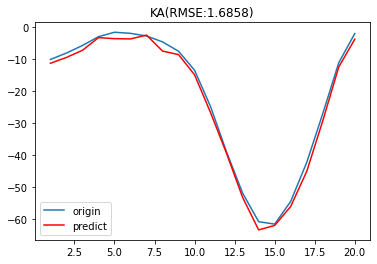

In [43]:
show_x = data_123_te
show_y = data_457_te_y
show_l = 20
column = 2
# net = net2
net.eval()
net.to('cpu')
criterion = torch.nn.MSELoss()
# predict = net(show_x)
# predict = predict.data.numpy()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=False)
predict_show = []
y_show = []
for batch in test_loader:
    s_x,s_y,_,_,_,_,_,_ = batch
    predict = net(s_x) 
    pred2 = predict.detach().numpy()
    predict_show.append(pred2) 
    trainloss = criterion(predict, s_y)
    y_s = s_y.detach().numpy()
    y_show.append(y_s)
predict_show = np.array(predict_show)
y_show = np.array(y_show)
# MSE_show = criterion(predict[:,column], show_y[:,column])
MSE_show =  criterion(torch.Tensor(predict_show[:,:,column]), torch.Tensor(y_show[:,:,column]))
predict = predict.data.numpy()
# 建立等差数列，（起始，终止，个数）
x = np.linspace(1,show_l,show_l)

plt.title('KA(RMSE:'+str('%.5g' % torch.sqrt(MSE_show))+')')
# plt.plot(x , show_y[:,column], label='origin')
plt.plot(x , show_y[:,column], label='origin')
# plt.plot(x, predict[:,column], color='red', label='predict')
plt.plot(x, predict_show[:,0,column], color='red', label='predict')
plt.legend()
plt.show()


In [44]:
adataset_kmmf = {}
data_457_te_y = np.array(data_457_te_y)
adataset_kmmf['GT'] = data_457_te_y
adataset_kmmf['Preds'] = predict_show
# np.save('../data/exportdata/dl_rf_-omse_lr001.npy',adataset_kmmf)

In [45]:
from scipy import io
# mat = np.load('../data/exportdata/dl_rf.npy',allow_pickle=True)
# io.savemat('../data/exportdata/dl_rf.mat', {'variables': mat})
io.savemat('../data/exportdata/dl_lr001.mat', {'variables': adataset_kmmf})

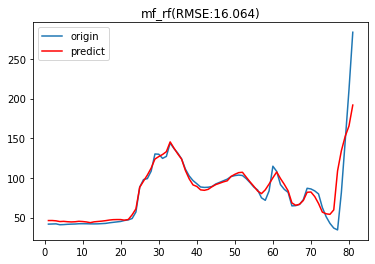

In [40]:
show_x = data_123_tr
show_y = data_457_tr_y
show_l = 81
column = 0
mf_namelist = ['mf_rf','mf_bm','ka']
net3 = net
net = net2
net.eval()
net.to('cpu')
criterion = torch.nn.MSELoss()
# predict = net(show_x)
# predict = predict.data.numpy()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=False)
predict_show = []
y_show = []
for batch in train_loader:
    s_x,s_y,_,_,_,_,_,_ = batch
    predict = net(s_x) 
    pred2 = predict.detach().numpy()
    predict_show.append(pred2) 
    trainloss = criterion(predict, s_y)
    y_s = s_y.detach().numpy()
    y_show.append(y_s)
predict_show = np.array(predict_show)
y_show = np.array(y_show)
# MSE_show = criterion(predict[:,column], show_y[:,column])
MSE_show =  criterion(torch.Tensor(predict_show[:,:,column]), torch.Tensor(y_show[:,:,column]))
predict = predict.data.numpy()
# 建立等差数列，（起始，终止，个数）
x = np.linspace(1,show_l,show_l)

plt.title(mf_namelist[column]+'(RMSE:'+str('%.5g' % torch.sqrt(MSE_show))+')')
# plt.plot(x , show_y[:,column], label='origin')
plt.plot(x , show_y[:,column], label='origin')
# plt.plot(x, predict[:,column], color='red', label='predict')
plt.plot(x, predict_show[:,0,column], color='red', label='predict')
plt.legend()
plt.show()